In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = np.load("/Users/mdn/Documents/PROJECTS/FreeMoCap_data/2023-10-05_max_jump_recording_sessions_KK_ML/session_2023-10-05_15_59_45/recording_16_04_29_gmt-4__ML_max_jump/output_data/center_of_mass/total_body_center_of_mass_xyz.npy")

Let's take a look at the data and see what we're dealing with. From Jon, we know that the recording is in XYZ, where Y is up and Z is depth.

In [4]:
data.shape

(1399, 3)

Let's trim by hand.
I just plotted it several times and adjusted the indices to choose where we want to cut the data.

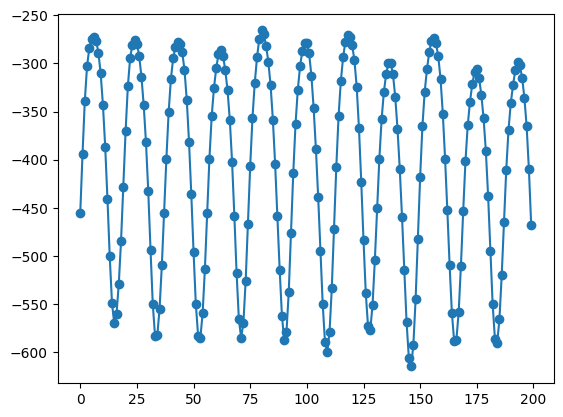

In [19]:
plt.plot(data[500:700, 2], marker='o')


In [20]:
t_start = 240
t_end = 440

time_step = 1./30.  # assume the cameras is consistently 30 FPS

height_velocity = np.diff(data[t_start:t_end, 2],axis=0)/time_step  # let's get the velocity from first-order diff
height_position = data[t_start:t_end-1, 2]  # and offset positions to match the trajectory length
time = np.linspace(0, (t_end-t_start)*time_step, num=height_position.shape[0])

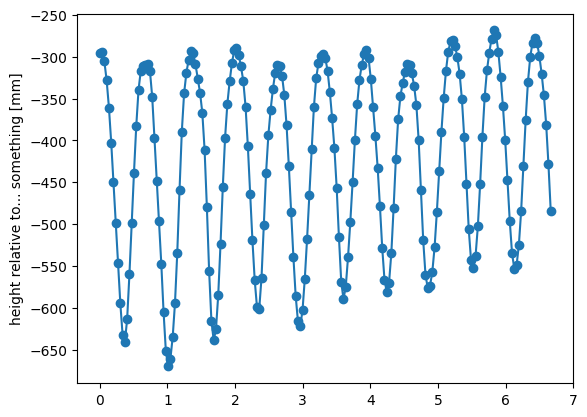

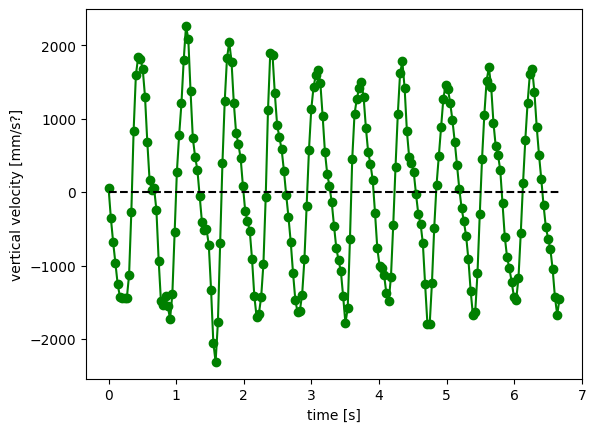

In [21]:
plt.figure(1)
plt.plot(time, height_position, marker='o')
plt.ylabel("height relative to... something [mm]")
plt.figure(2)
plt.plot(time, height_velocity, marker='o', color = 'g')
plt.plot(time, np.zeros_like(time), color='k', linestyle='--')
plt.ylabel("vertical velocity [mm/s?]")
plt.xlabel("time [s]")
plt.show()

Let's take a few poincare sections and compare the data!
Let's take one at the vel

In [22]:
liftoff_time_stamps = []
bottom_time_stamps = []
apex_time_stamps = []

for t in range(height_velocity.size-2):
    if (height_velocity[t+2]<height_velocity[t+1]
        and height_velocity[t] < height_velocity[t+1]):
        liftoff_time_stamps.append(t+1)

for t in range(height_velocity.size-1):
    if height_velocity[t+1] > 0 and height_velocity[t] <= 0:
        bottom_time_stamps.append(t)
    if height_velocity[t+1] < 0 and height_velocity[t] >= 0:
        apex_time_stamps.append(t)

print(f"number of iterations at bottom: ", len(bottom_time_stamps))
print(f"number of iterations at apex: ", len(apex_time_stamps))



number of iterations at bottom:  10
number of iterations at apex:  11


check visually with a phase plot to see which poincare section makes the most sense

Text(0, 0.5, 'velocity [??]')

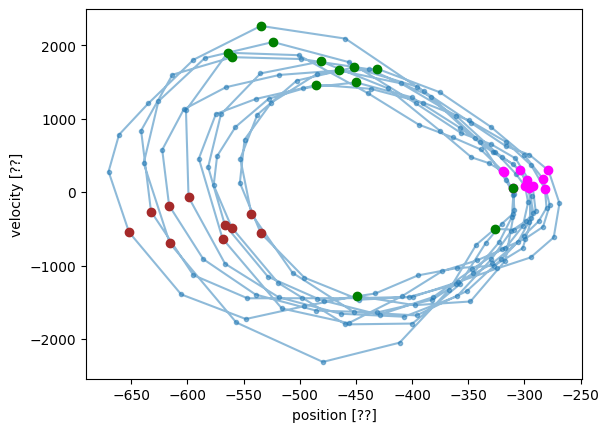

In [23]:
# state space plot
plt.plot(height_position, height_velocity, marker='.', alpha=0.5, zorder=1)
plt.scatter(height_position[0], height_velocity[0], marker="v", color='red', zorder=2)  # start
plt.scatter(height_position[bottom_time_stamps], height_velocity[bottom_time_stamps], color='brown', marker='o', zorder=2)
plt.scatter(height_position[apex_time_stamps], height_velocity[apex_time_stamps], color='magenta', marker='o', zorder=2)
plt.scatter(height_position[liftoff_time_stamps], height_velocity[liftoff_time_stamps], color='green', marker='o', zorder=2)
plt.xlabel('position [??]')
plt.ylabel('velocity [??]')

Great, let's use the bottom (brown circles on the left), it clearly has less spread! (better resolution since it is slower, and we're recording at only 30 FPS).
The lift-off event (top, green) is nicely bunched, but it looks like the Poincare section is relatively tangential to the flow, which would make it quite sensitive: we generally want a cut that is as perpendicular to the flow as possible.

Now let's get the (assumed) limit-cycle, and perturbations

In [10]:
poincare_intersections = np.stack((height_position[bottom_time_stamps],
                            height_velocity[bottom_time_stamps]))

limit_cycle = np.mean(poincare_intersections, axis=1)

print(f"The limit-cycle location is assumed to be at the average position of all the intersections: ", limit_cycle)


The limit-cycle location is assumed to be at the average position of all the intersections:  [2291.69228465  -62.32474017]


Text(0.5, 1.0, 'intersections on the poincare map, and assumed Limit-Cycle (star)')

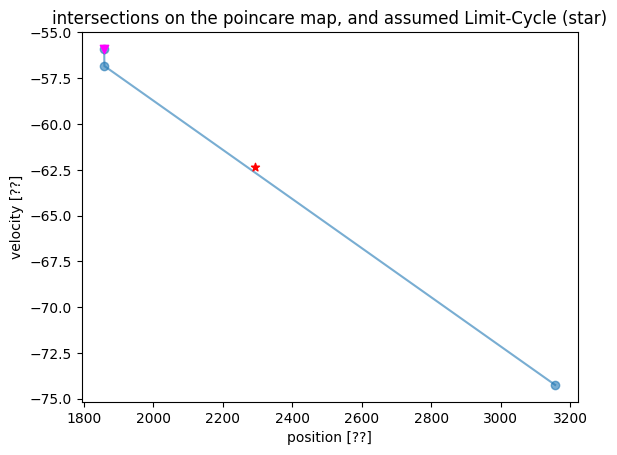

In [11]:
plt.scatter(limit_cycle[0], limit_cycle[1], color="red", marker="*", zorder=2)
plt.plot(poincare_intersections[0, :], poincare_intersections[1, :], marker='o', zorder=1, alpha=0.6)
plt.scatter(poincare_intersections[0, 0], poincare_intersections[1, 0], marker="v", color="magenta", zorder=2)
plt.xlabel('position [??]')
plt.ylabel('velocity [??]')
plt.title("intersections on the poincare map, and assumed Limit-Cycle (star)")

Text(0.5, 1.0, 'Perturbations')

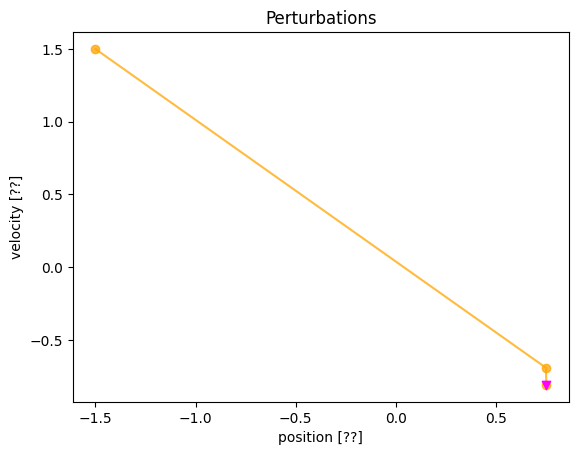

In [12]:
perturbations = np.atleast_2d(limit_cycle).T-poincare_intersections
perturbations /= np.atleast_2d(np.mean(np.abs(perturbations), axis=1)).T
plt.plot(perturbations[0, :], perturbations[1, :], color="orange", marker='o', alpha=0.75, zorder=1)
plt.scatter(perturbations[0, 0], perturbations[1, 0], color="magenta", marker="v", zorder=2)  # not sure how to bring this to the forefront
plt.xlabel('position [??]')
plt.ylabel('velocity [??]')
plt.title("Perturbations")

Let's fit the Jacobian via least-squares:

In [13]:
sol = np.linalg.lstsq(perturbations[:, :-1].T, perturbations[:, 1:].T, rcond=None)
J = sol[0]

Now let's sanity check, and see if any of the perturbations can be predicted with our fit solution: $\delta_{k+1} = J \delta_{k}$

In [14]:
perturbations[:, 1]

array([ 0.74951439, -0.69129904])

In [15]:
prediction = np.matmul(J, np.atleast_2d(perturbations[:, 0]).T)

print(f"The perturbation at time k=1: ", perturbations[:, 1])
print(f"The prediction from our linear fit, starting from the perturbation at time k=0: ", prediction)

The perturbation at time k=1:  [ 0.74951439 -0.69129904]
The prediction from our linear fit, starting from the perturbation at time k=0:  [[-30.53837247]
 [-29.72688854]]


Not too surprising, I guess, since we don't have that much data.... :\

In [16]:
sol[1]

array([], dtype=float64)